# Appendix A: Regression with Linear and Radial Basis Function Models

To become familiar with the RBF model, solve a regression problem of your choice. Take a small dataset from the UCI repository of machine learning benchmark datasets and solve it with an RBF model. To help with getting started, snippets of code solving linear and RBF models is given in Appendix A. The dataset housing.data is available in the module notes pages.
Solve the above problem by gradient descent, starting from a random guess of the pa- rameters w and adapting it with random presentation of data (i.e. stochastic gradient descent). Draw a graph showing convergence of the error.

(506, 13) (506, 1)
110.58049674804326 168.29717660792846


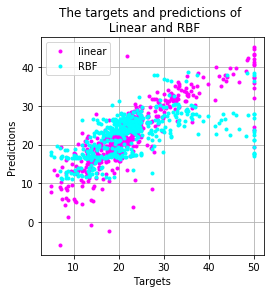

[[ 17.07464492   9.44904829 -16.10034555   6.86776599 -25.2627733
   -6.78080604   3.2057219    8.16497648  10.57362135 -20.01695518
  -19.05309177 -11.99623245  -0.89539972   9.08903857   4.61578995
   -1.65738036  18.9861051   -4.48540418  19.21212121   7.66412987]]


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use(['science','ieee'])

rawData = np.genfromtxt('housing.data') 
N, pp1 = rawData.shape
np.random.seed(0)

# Last column is target
X = np.matrix(rawData[:,0:pp1-1]) 
y = np.matrix(rawData[:,pp1-1]).T 
print(X.shape, y.shape)

# Solve linear regression, plot target and prediction 
w = (np.linalg.inv(X.T*X)) * X.T * y
yh_lin = X*w

# J = 20 basis functions obtained by k-means clustering 
# sigma set to standard deviation of entire data
from sklearn.cluster import KMeans

J = 20;
kmeans = KMeans(n_clusters=J, random_state=0).fit(X) 
sig = np.std(X)

# Construct design matrix 
U = np.zeros((N,J))
for i in range(N):
    for j in range(J):
        U[i][j] = np.linalg.norm(X[i] - kmeans.cluster_centers_[j]) / sig
        
# Solve RBF model, predict and plot
w = np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) * y 
yh_rbf = np.dot(U,w)

print(np.linalg.norm(y-yh_lin), np.linalg.norm(y-yh_rbf))
plt.figure(figsize=(4,4))
plt.plot(y, yh_lin, '.', Color='magenta', label='linear')
plt.plot(y, yh_rbf, '.', Color='cyan', label='RBF')
plt.grid()
plt.title('The targets and predictions of \n Linear and RBF')
plt.xlabel('Targets')
plt.ylabel('Predictions')
plt.legend()
plt.show()
print(w.T)

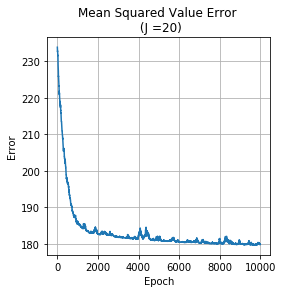

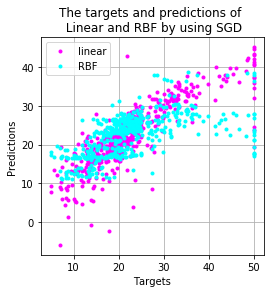

[[ 1.58364165  0.64950863  0.71449077  3.3465817   1.38756656 -1.43268716
   0.85314179  0.29863487 -0.41217193 -0.19342807 -0.36478159  1.693413
   1.03915221 -0.38881818  0.12759023  0.1128523   0.88987575  0.67173207
  -0.1316274  -1.09152231]]


In [2]:
T = 10000
alpha = 1e-4
w_sgd = np.random.randn(J, 1)
loss = np.zeros(T)

for t in range(T):
    
    s_num = np.random.randint(0, N)
    U_ = U[s_num:s_num+1]
    y_ = y[s_num:s_num+1]
    
    w_sgd = w_sgd + alpha * U_.T @ (y_ - U_ @ w_sgd)
    loss[t] = np.linalg.norm(y - U @ w_sgd)
    
plt.figure(figsize=(4,4))    
plt.plot(loss)
plt.grid()
plt.title('Mean Squared Value Error \n (J ={})'.format(J))
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

yh_sgd = np.dot(U,w_sgd)
plt.figure(figsize=(4,4))
plt.plot(y, yh_lin, '.', Color='magenta', label='linear')
plt.plot(y, yh_rbf, '.', Color='cyan', label='RBF')
plt.grid()
plt.title('The targets and predictions of \n Linear and RBF by using SGD')
plt.xlabel('Targets')
plt.ylabel('Predictions')
plt.legend()
plt.show()

print(w_sgd.T)

# Appendix B: Mountain Car Control Problem, Discrete States

Consider the mountain car learning control problem given in Appendix B. where the action value function is discretized and represented in a table. Implement a learning controller that uses an RBF model for approximating the value function in two different ways:

• Obtain the value function learned by the tabular discretization method and build an RBF approximator to it with different numbers of basis functions and see if a policy derived from the approximation is capable of driving the car to the top of the hill. How does the accuracy of approximation change with the number of basis functions used?

FINISH


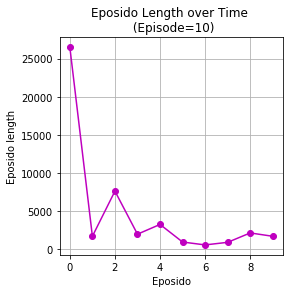

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import gym
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


env_name = "MountainCar-v0" 
env = gym.make(env_name) 
obs = env.reset() 
# env.render()

# Some initializations 
#
n_states = 40
episodes = 10
initial_lr = 1.0 
min_lr = 0.005
gamma = 0.99 
max_stps = 300 
epsilon = 0.05
env = env.unwrapped 
env.seed() 
np.random.seed(0)

# Quantize the states
#
def discretization(env, obs):
    env_low = env.observation_space.low 
    env_high = env.observation_space.high 
    env_den = (env_high - env_low) / n_states 
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low) / pos_den) 
    vel_scaled = int((obs[1] - vel_low) / vel_den) 
    return pos_scaled, vel_scaled

q_table = np.zeros((n_states, n_states, env.action_space.n)) 
total_steps = 0
q_table_record = np.zeros((episodes, n_states, n_states, env.action_space.n))
steps_record = []

for episode in range(episodes): 
    obs = env.reset() 
    total_reward = 0
    alpha = max(min_lr, initial_lr*(gamma**(episode//100))) 
    steps = 0
    while True:
#         env.render()
        pos, vel = discretization(env, obs)
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n) 
        else:
            a = np.argmax(q_table[pos][vel]) 
        obs, reward, terminate, _ = env.step(a) 
        total_reward = abs(obs[0]+0.5)
        pos_, vel_ = discretization(env, obs)
    
        # Q function update
        # pos --> position; vel-->velucity; a-->action
        q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+gamma*np.max(q_table[pos_][vel_])) 
        steps += 1
        if terminate:
            break
#         print('\r episode={} step={}'.format(episode, steps), end='')
    q_table_record[episode] = q_table
    steps_record.append(steps)
print('FINISH')

plt.figure(figsize=(4,4))
plt.plot(steps_record, 'o-', c='m')
plt.title('Eposido Length over Time \n (Episode={})'.format(episodes))
plt.xlabel('Eposido')
plt.ylabel('Eposido length')
plt.grid()
plt.savefig('Eposido Length over Time (Episode={})'.format(episodes))
plt.show()
# env.close()
# while True: 
#     env.render()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


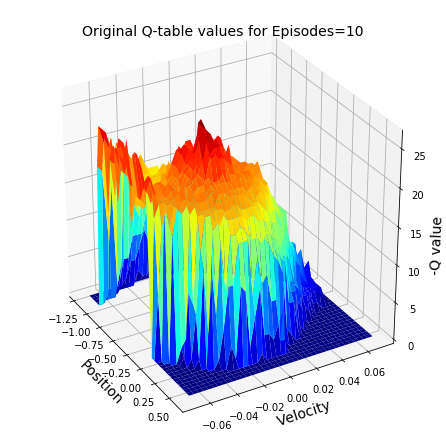

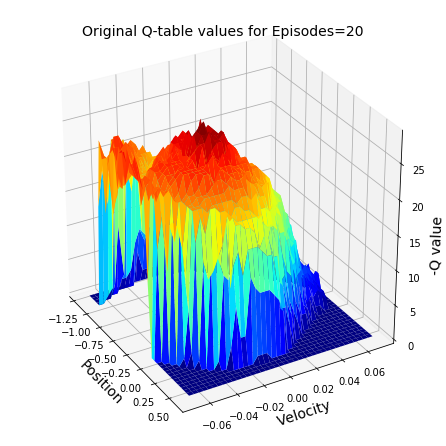

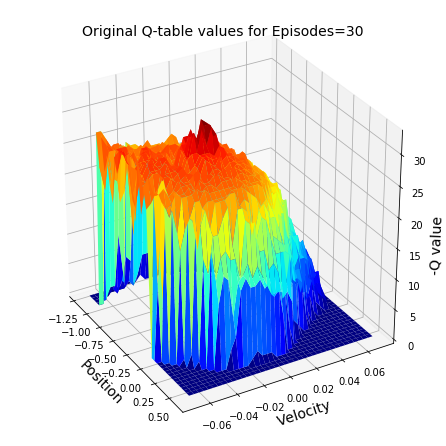

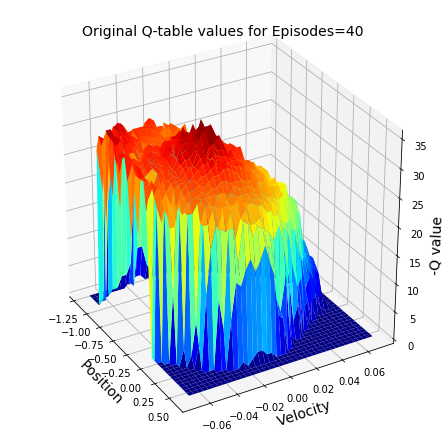

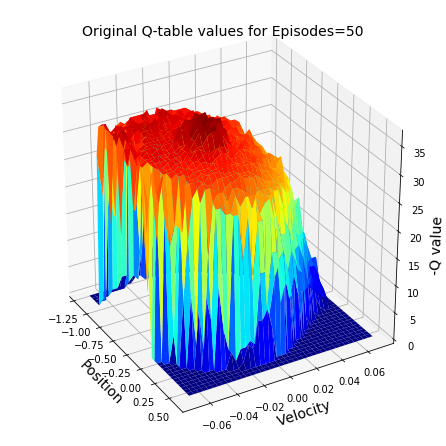

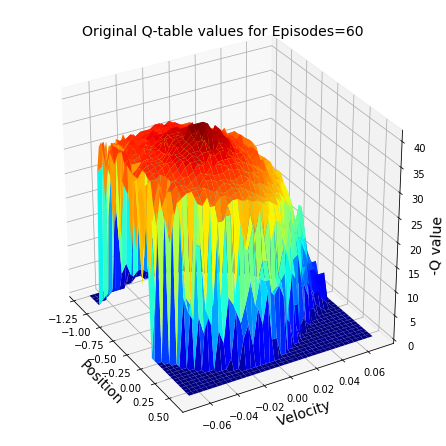

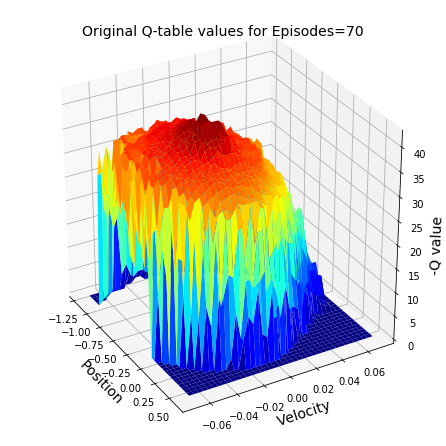

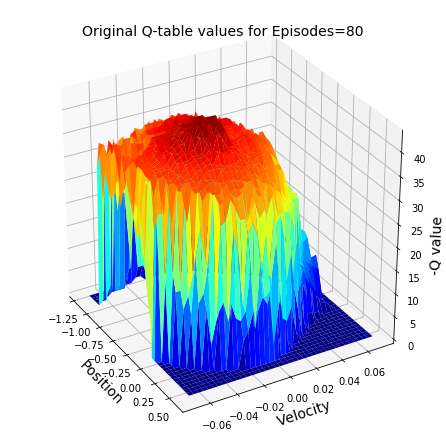

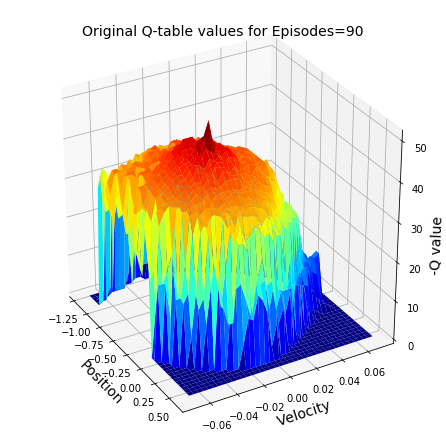

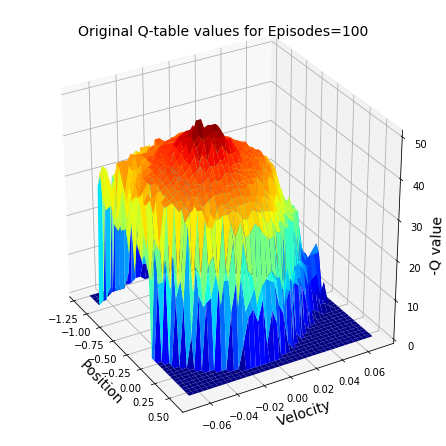

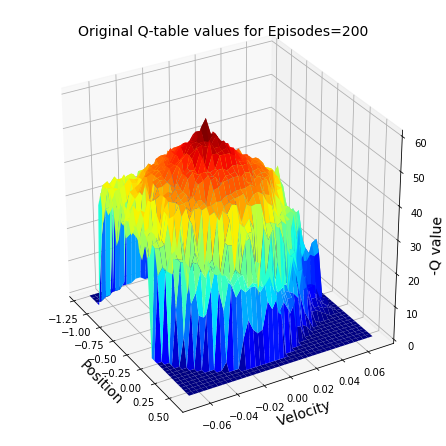

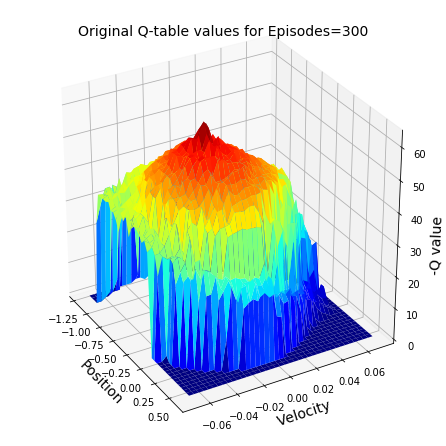

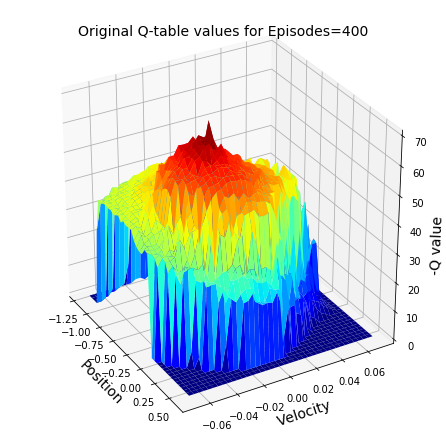

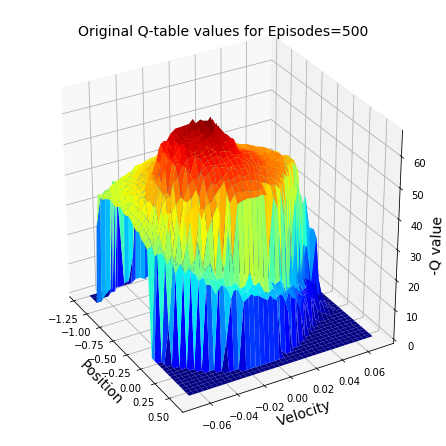

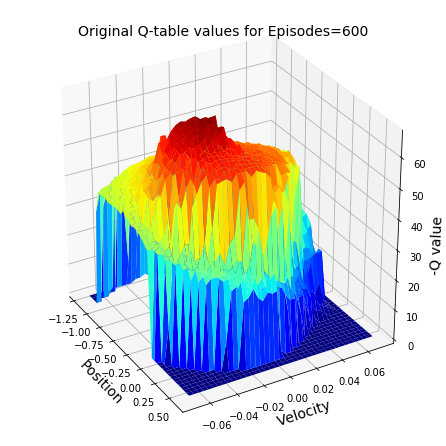

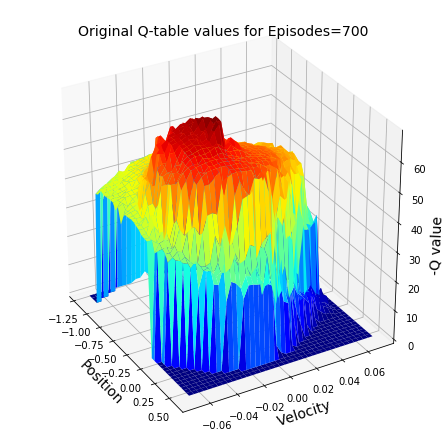

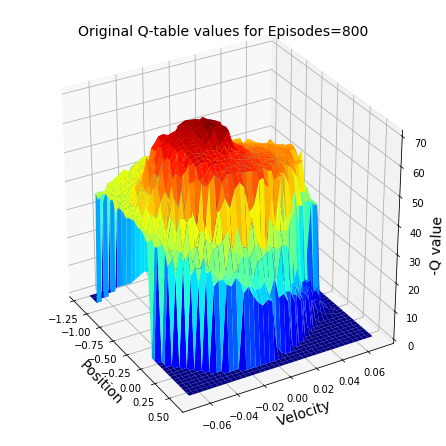

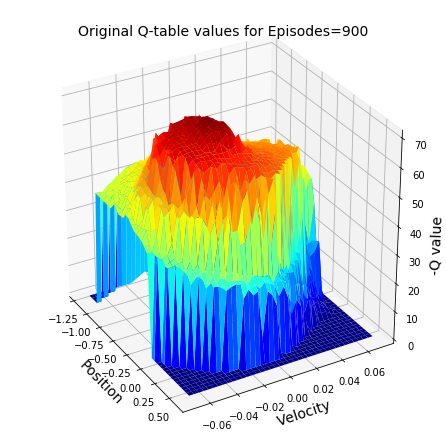

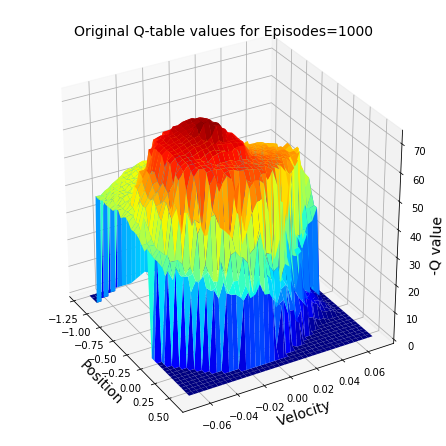

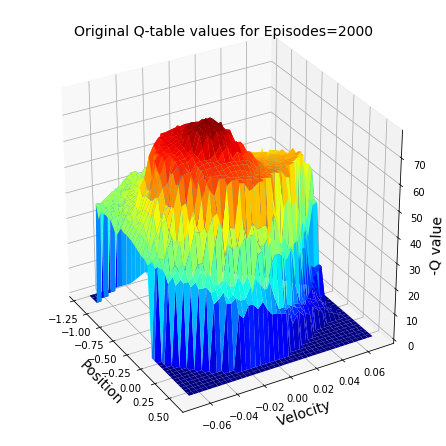

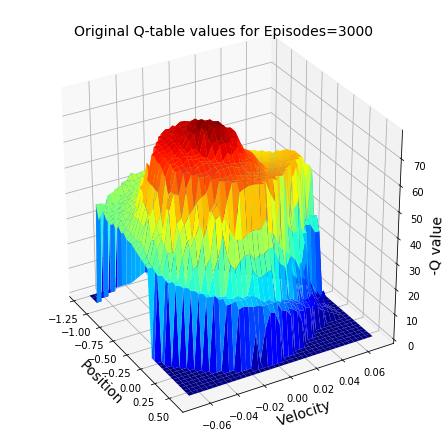

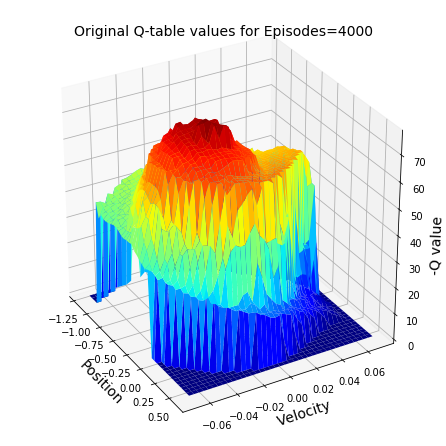

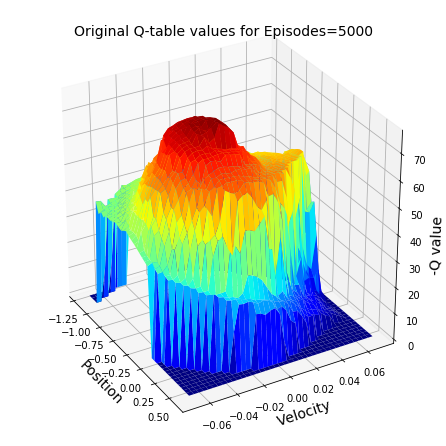

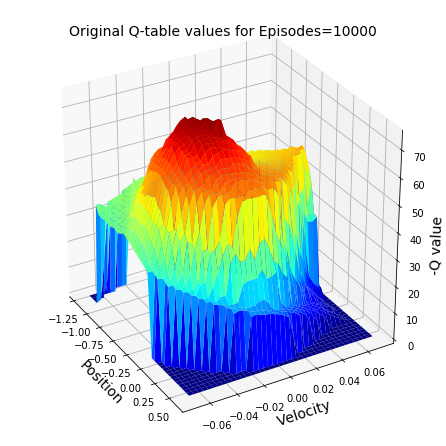

In [111]:
# episode_list =[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 10000]
# for i in episode_list:
#     fig = plt.figure(figsize=(6,6))
#     ax = Axes3D(fig)
#     max_value_action = np.max(q_table_record[i], 2)
#     surf = ax.plot_surface(pos_grid, vel_grid, -max_value_action, cstride=1, rstride=1, cmap=cm.jet)
#     ax.set_title('Original Q-table values for Episodes={}'.format(i), fontsize=14)
#     ax.set_xlabel('Position', fontsize=14)
#     ax.set_ylabel('Velocity', fontsize=14)
#     ax.set_zlabel('-Q value', fontsize=14)
#     ax.view_init(30,-30)
# #     plt.savefig('q_table(episodes={})'.format(i))
# plt.show()

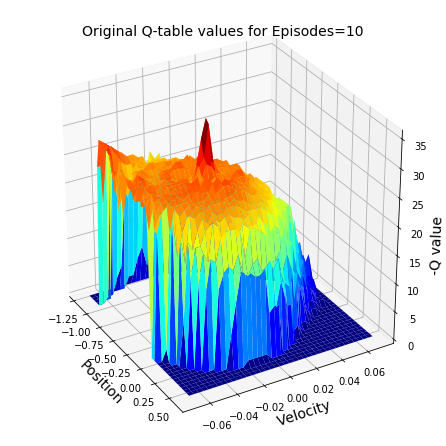

In [2]:
# episodes = 10
# q_table = q_table_record[10]
# Plotting original Q_table
pos = np.linspace(-1.2, 0.6, n_states)
vel = np.linspace(-0.07, 0.07, n_states)
pos_grid, vel_grid = np.meshgrid(pos, vel)

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
max_value_action = np.max(q_table, 2)
surf = ax.plot_surface(pos_grid, vel_grid, -max_value_action, 
                       cstride=1, rstride=1, cmap=cm.jet)
# ax.contourf(pos_grid, vel_grid, -max_value_action, zdir='z', offset=-10, cmap=plt.get_cmap('rainbow'))
ax.set_title('Original Q-table values for Episodes={}'.format(episodes), fontsize=14)
ax.set_xlabel('Position', fontsize=14)
ax.set_ylabel('Velocity', fontsize=14)
ax.set_zlabel('-Q value', fontsize=14)
ax.view_init(30,-30)
plt.show()

558.2567046092988


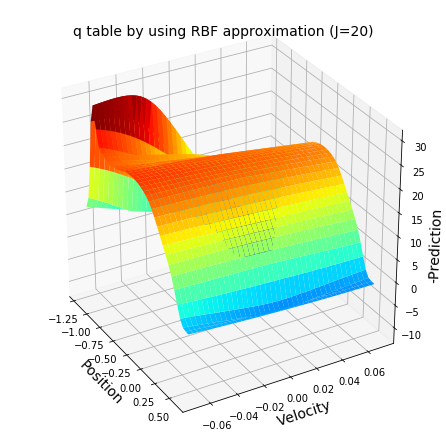

In [3]:
from sklearn.cluster import KMeans
np.random.seed(0)

actions = 3
N = n_states * n_states
features = 2
concat = np.dstack((pos_grid, vel_grid))
X = concat.reshape(N, features)
J_list =[20]
error = []

for J in J_list:

    kmeans = KMeans(n_clusters=J, random_state=0).fit(X) 
    sig = np.std(X)

    # Constructing design matrix
    U = np.zeros((N, J))
    for i in range(N):
        for j in range(J):
            U[i][j] = np.linalg.norm(X[i] - kmeans.cluster_centers_[j]) / sig
#             U[i][j] = np.exp(-np.linalg.norm(X[i] - kmeans.cluster_centers_[j])**2 / (2 * sig**2))

    # Calculating the optimal weights for the thre actions
    w_rbf = np.dot((np.linalg.pinv(np.dot(U.T, U))), U.T) @ q_table.reshape(n_states*n_states, actions)
    yh_rbf = np.dot(U, w_rbf)
    Z = yh_rbf.reshape(n_states, n_states, actions)
    Z = np.max(Z, 2)

    error.append(np.linalg.norm(yh_rbf-q_table.reshape(n_states*n_states, actions)))
    print(error[len(error)-1])
    
    # plot RBF
    fig = plt.figure(figsize=(6,6))
    ax = Axes3D(fig)
    surf = ax.plot_surface(pos_grid, vel_grid, -Z, cmap=cm.jet, cstride=1, rstride=1)
    ax.set_title('q table by using RBF approximation (J={})'.format(J), fontsize=14)
    ax.set_xlabel('Position', fontsize=14)
    ax.set_ylabel('Velocity', fontsize=14)
    ax.set_zlabel('-Prediction', fontsize=14)
    ax.view_init(30,-30)
#     plt.savefig('RBF(J={})'.format(J))
    plt.show()
#     print(w.T)

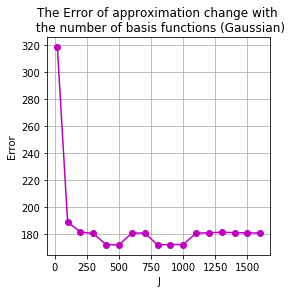

In [226]:
# plt.figure(figsize=(4,4))
# plt.plot(J_list, error, 'o-', c='m')
# plt.title('The Error of approximation change with \n the number of basis functions (Gaussian)' )
# plt.xlabel('J')
# plt.ylabel('Error')
# plt.grid()

In [234]:
# Testing

# env.render()
env.seed()
np.random.seed(0)
yh_rbf = np.dot(U, w_rbf)
q_table_rbf = yh_rbf.reshape(n_states, n_states, actions)

for episode in range(episodes): 
    obs = env.reset() 
    total_reward = 0
    steps = 0
    while True:
#         env.render()
        pos, vel = discretization(env, obs)
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n) 
        else:
            a = np.argmax(q_table_rbf[pos][vel]) 
        obs, reward, terminate, _ = env.step(a) 
        if terminate or steps > 1e5:
            break 
        steps += 1
    if terminate:
        print('episode={}; step={}'.format(episode, steps))
    else:
        print('episode={}; FAIL'.format(episode))

print('FINISH') 
# env.close()
# while True: 
#     env.render()

episode=0; step=977
episode=1; step=219
episode=2; step=1428
episode=3; step=1435
episode=4; step=2561
episode=5; step=1734
episode=6; step=5204
episode=7; step=3523
episode=8; step=2348
episode=9; step=5407
FINISH


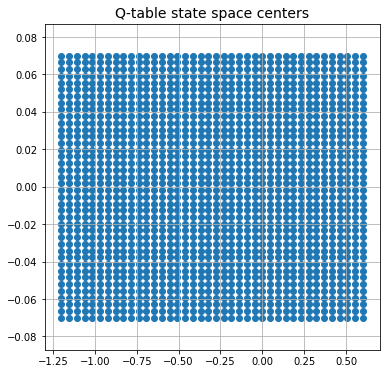

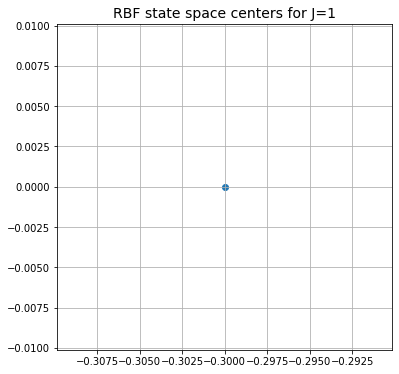

In [232]:
fig = plt.figure(figsize=(6,6))
plt.scatter(pos_grid, vel_grid)
plt.grid()
plt.title('Q-table state space centers', fontsize=14)
plt.show()

fig = plt.figure(figsize=(6,6))
plt.title("RBF state space centers for J={}".format(J), fontsize=14)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1])
# plt.scatter(pos_grid, vel_grid)
plt.grid()
plt.show()

• Learn the weights of the RBF approximation on-line using either a Q-learning or SARSA update rule and compare the results with the tabular method.

 J=100 episode=999 step=129 

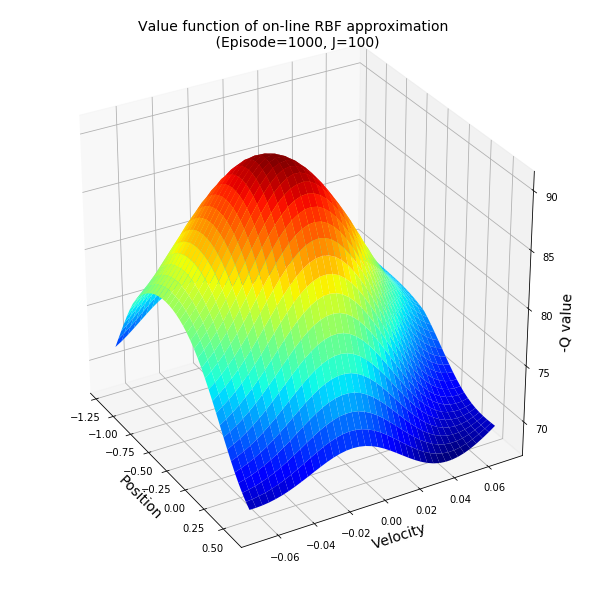

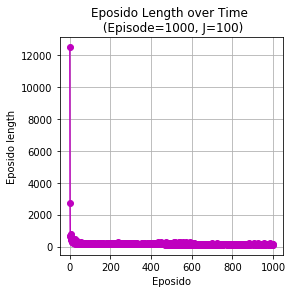

FINISH


In [243]:
%matplotlib inline
import matplotlib.pyplot as plt
import gym
import numpy as np
import sklearn.preprocessing
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor

def featurize_state(state):
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

def predict(x):
    p = np.zeros(env.action_space.n)
    for i in range(env.action_space.n):
        p[i] = models[i].predict([x])
    return p

J_list = [100]
for J in J_list:
    
    env_name = "MountainCar-v0" 
    env = gym.make(env_name) 
    obs = env.reset() 
    env.seed() 
    np.random.seed(0)
    # env.render()
    
    # Some initializations 
    #
    features = 2
    actions = 3
    # w_sgd = np.random.randn(J, actions)
    # alpha = 1e-5
    episodes = 1000
    gamma = 0.99
    epsilon = 0.05
    env = env.unwrapped
    
    steps_record = []
    
    observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(observation_examples)
    featurizer = RBFSampler(n_components=J)
    featurizer.fit(observation_examples)
    models = []
    for _ in range(env.action_space.n):
        model = SGDRegressor(learning_rate="constant")
        model.partial_fit([featurize_state(env.reset())], [0])
        models.append(model)

    # q learning
    for episode in range(episodes): 
        obs = env.reset() 
        steps = 0
        while True:
    #         env.render()
            x = featurize_state(obs)

            if np.random.uniform(low=0, high=1) < epsilon:
                a = np.random.choice(env.action_space.n) 
            else:
                a = np.argmax(predict(x))
    #             a = np.argmax(x @ w_sgd)

            obs, reward, terminate, _ = env.step(a) 
            x_ = featurize_state(obs)
    #         q_values_next = x_ @ w_sgd
            q_values_next = predict(x_)

            # w update
    #         prediction = x @ w_sgd[:,a]
            td_target = reward + gamma * np.max(q_values_next)
    #         w_sgd[:,a] = w_sgd[:,a] + alpha * (td_target - prediction) * prediction
            models[a].partial_fit([x], [td_target])

            steps += 1
            if terminate:
                break
            print('\r J={} episode={} step={} '.format(J, episode, steps), end='')         
#         print()
        steps_record.append(steps)
        
    # Plotting original Q_table
    n_states = 40

    pos = np.linspace(-1.2, 0.6, n_states)
    vel = np.linspace(-0.07, 0.07, n_states)
    pos_grid, vel_grid = np.meshgrid(pos, vel)

    q_table_sgd = np.zeros((n_states, n_states, actions))
    for i,p in enumerate(pos):
        for j,v in enumerate(vel):
            q_table_sgd[i,j] = predict(featurize_state([p,v]))

    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    max_value_action = np.max(q_table_sgd, 2)
    surf = ax.plot_surface(pos_grid, vel_grid, -max_value_action, cstride=1, rstride=1, cmap=cm.jet)
    # ax.contourf(pos_grid, vel_grid, -max_value_action, zdir='z', offset=-10, cmap=plt.get_cmap('rainbow'))
    ax.set_title('Value function of on-line RBF approximation \n (Episode={}, J={})'.format(episodes, J), fontsize=14)
    ax.set_xlabel('Position', fontsize=14)
    ax.set_ylabel('Velocity', fontsize=14)
    ax.set_zlabel('-Q value', fontsize=14)
    ax.view_init(30,-30)
    plt.savefig('On-line RBF approximation (Episode={} J={})'.format(episodes, J))
    plt.show()
    
    plt.figure(figsize=(4,4))
    plt.plot(steps_record, 'o-', c='m')
    plt.title('Eposido Length over Time \n (Episode={}, J={})'.format(episodes, J))
    plt.xlabel('Eposido')
    plt.ylabel('Eposido length')
    plt.grid()
    plt.savefig('Eposido Length over Time (Episode={} J={})'.format(episodes, J))
    plt.show()

print('FINISH')
# env.close()

So far, we have fixed the size of the RBF network arbitrarily. Often we might require the size of a model we choose to be adaptive with respect to the complexity of the problem. A particular method to achieve such a constructive model (a growing network) is the pioneering work of John Platt [1], extended in [2] using the extended Kalman filter.


In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
import gym
import numpy as np
import sklearn.preprocessing
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import KMeans

def featurize_state(state):
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

def predict(models, x):
    p = np.zeros(env.action_space.n)
    for i in range(env.action_space.n):
        p[i] = models[i].predict([x])
    return p

def define_function(J):
    kmeans = KMeans(n_clusters=J, random_state=0).fit(observation_examples)
    featurizer = RBFSampler(n_components=J)
    featurizer.fit(observation_examples)
    models = []
    for _ in range(env.action_space.n):
        model = SGDRegressor(learning_rate="constant")
        model.partial_fit([featurize_state(observation_examples[0])], [0])
        models.append(model)
    return kmeans, featurizer, models, J

def min_center_distance(kmeans, state):
    distances = []
    for center in kmeans.cluster_centers_:
        distances.append(np.linalg.norm(center-state))
    return np.min(distances)

env_name = "MountainCar-v0" 
env = gym.make(env_name) 
obs = env.reset() 
env.seed() 
np.random.seed(0)
# env.render()

# Some initializations 
#
E = 1
D = 0.5

features = 2
actions = 3
w_sgd = np.random.randn(J, actions)
# alpha = 1e-5
episodes = 10
gamma = 0.99
epsilon = 0.05
env = env.unwrapped

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

kmeans, featurizer, models, J = define_function(1)


# q learning
for episode in range(episodes): 
    obs = env.reset() 
    steps = 0
    while True:
#         env.render()
        x = featurize_state(obs) 
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n) 
        else:
            a = np.argmax(predict(models, x))
            
        obs, reward, terminate, _ = env.step(a) 
        x_ = featurize_state(obs)
        q_values_next = predict(models, x_)
        td_target = reward + gamma * np.max(q_values_next)
        
        d = min_center_distance(kmeans, obs)
        e = np.linalg.norm(td_target - np.max(predict(models, x)))
        
        if  (e > E) and (d > D):
            kmeans, featurizer, models, J = define_function(J+1)
        else:
            models[a].partial_fit([x], [td_target])
        
        steps += 1
        print('\r episode={}; step={}; J={}'.format(episode, steps, J), end="")
        if terminate:
            break
    print()
    
print('FINISH')  
# env.close()

TypeError: partial_fit() missing 1 required positional argument: 'y'